## Project 1 Baseband Communications
### ECE 5625
By Caleb Moore, Kevyn Kelso

### I.A.1 System Calibration - No Noise

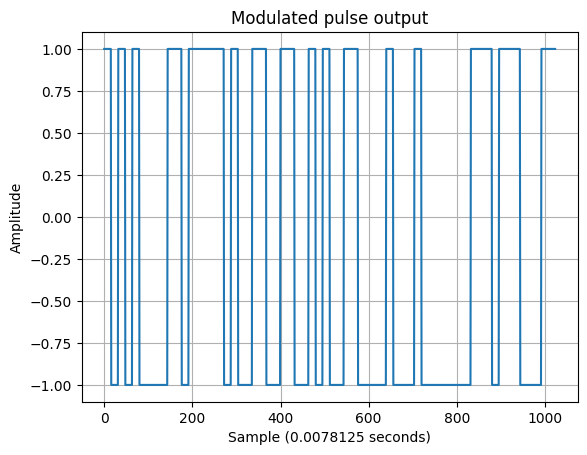

Energy per bit: 0.125 J
Theoretical energy per bit: -9.031 dB


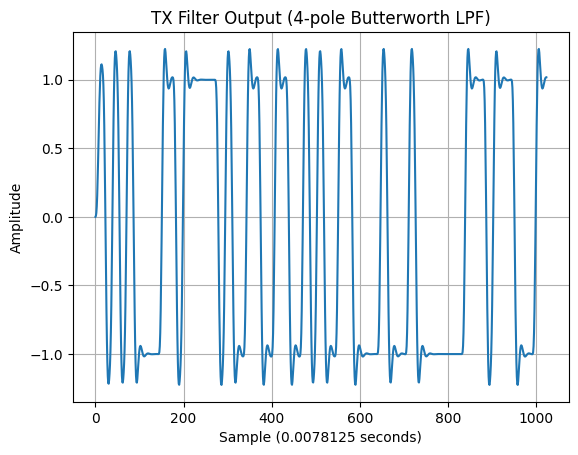

Energy per bit after applying TX filter: 0.112209 J


In [29]:
# Q1
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import butter, lfilter

# Simulation Parameters
SAMPLE_RATE = 128  # Hz
SAMPLE_TIME = 1 / SAMPLE_RATE  # ~7.8ms
NUM_BITS = 1024
SAMPLES_PER_BIT = 16
BIT_RATE = SAMPLE_RATE / SAMPLES_PER_BIT  # Bits/second
BIT_PERIOD = 1 / 8  # seconds

# Generate random bits and NRZ modulation
bits = np.random.randint(0, 2, NUM_BITS)
modulator_output = 2 * bits - 1  # NRZ modulation: 1 -> +1, 0 -> -1

# Rectangular pulse shaping
rect_pulse = np.ones(SAMPLES_PER_BIT)
modulator_output = np.kron(modulator_output, rect_pulse) # python equivalent to matlab rectpluse
# Note: only plotting first 64 bits for visibility
plt.plot(modulator_output[0:1024], label="Modulated pulse output")
plt.title("Modulated pulse output")
plt.xlabel(f"Sample ({1/SAMPLE_RATE} seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Energy per bit calculation
# Measure the energy per bit out of the modulator, by squaring and summing the
# complex absolute value of the modulator output. The sum is then divided by
# the number of samples taken and multiplied by the bit period.
sq_mod = np.abs(modulator_output)**2
total_energy = np.sum(sq_mod)
energy_per_bit = (total_energy / len(modulator_output)) * BIT_PERIOD
print(f"Energy per bit: {energy_per_bit} J")

# Theoretical energy per bit
theoretical_energy_per_bit = 10 * np.log10(1 / 8)
print(f"Theoretical energy per bit: {theoretical_energy_per_bit:.3f} dB")

# Transmit filter (4-pole Butterworth low-pass, fc = 8 Hz)
def butter_lowpass(cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Apply the transmit filter
cutoff_frequency = 8  # Hz
filtered_signal = lowpass_filter(modulator_output, cutoff_frequency, SAMPLE_RATE)

plt.plot(filtered_signal[0:1024], label="TX Filter Output")
plt.title("TX Filter Output (4-pole Butterworth LPF)")
plt.xlabel(f"Sample ({1/SAMPLE_RATE} seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Q2
# Measure the energy per bit out of the transmit filter using the method described
# above. Is the energy per bit out of the transmit filter higher or lower than the
# energy per bit out of the modulator. Why?
sq_mod = np.abs(filtered_signal)**2
total_energy = np.sum(sq_mod)
energy_per_bit = (total_energy / len(filtered_signal)) * BIT_PERIOD
print(f"Energy per bit after applying TX filter: {energy_per_bit:.6f} J")

The energy per bit out of the transmit filter is lower than the energy per bit out of the modulator because some energy is lost due to filtering.

### I.A.2 System Calibration - No Noise, Spectral Display

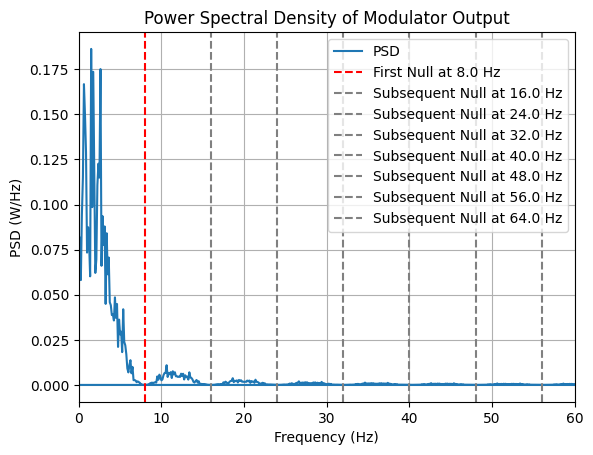

In [36]:
FFT_LENGTH = 1024
NUM_FFTS = 10
RESOLUTION_BANDWIDTH = SAMPLE_RATE / FFT_LENGTH # 0.125Hz

psd_avg = np.zeros(FFT_LENGTH // 2 + 1)
for _ in range(NUM_FFTS):
    seg = modulator_output[_ * FFT_LENGTH : (_ + 1) * FFT_LENGTH]
    fft_result = np.fft.fft(seg, FFT_LENGTH)
    fft_mag = np.abs(fft_result) / FFT_LENGTH
    psd = fft_mag**2
    psd_avg += psd[:FFT_LENGTH // 2 + 1]

psd_avg /= NUM_FFTS
psd_avg /= RESOLUTION_BANDWIDTH

freqs = np.fft.fftfreq(FFT_LENGTH, 1 / SAMPLE_RATE)[:FFT_LENGTH // 2 + 1]
plt.plot(freqs, psd_avg, label="PSD")
plt.title("Power Spectral Density of Modulator Output")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (W/Hz)")
plt.xlim(0, 60)
plt.grid()

first_null = 1 / BIT_PERIOD
plt.axvline(x=first_null, color='red', linestyle='--', label=f'First Null at {first_null} Hz')
while first_null < 60:
    first_null += (1 / BIT_PERIOD)
    plt.axvline(x=first_null, color='gray', linestyle='--', label=f"Subsequent Null at {first_null} Hz")
plt.legend()
plt.show()
